## Astrodynamics computations, comparaison with Poliastro

This notebook explores some classic astrodynamics computations like computing heliocentric orbits in the two body problem and computing Lagrange points in the CRTBP and comparaison manually obtained results with Poliastro astrodynamics library

### Heliocentric orbits, The two-body problem 


The equations of motion of the two body problem are

\begin{equation}
\begin{bmatrix} \ddot{x} \\ \ddot{y} \\ \ddot{z} \end{bmatrix} = -\cfrac{\mu}{\|r\|^3} \begin{bmatrix} x \\ y \\ z \end{bmatrix}
\end{equation}

$ r = \begin{bmatrix} x & y & z \end{bmatrix}^T$ is the position vector of the secondary body

$\mu = G \cdot m_S$ is the gravitional parameter of the central body (the Sun in our case)

#### Defining and plotting orbits using Poliastro 

In [24]:
#Required packages
from astropy import time
from poliastro.twobody.orbit import Orbit
from poliastro.bodies import Earth, Sun
from poliastro.plotting import StaticOrbitPlotter

In [28]:
#Retrieving the Earth orbit
earth = Orbit.from_body_ephem(Earth)

#Retrieving Apophis asteroid orbit
Apophis = Orbit.from_sbdb('apophis')

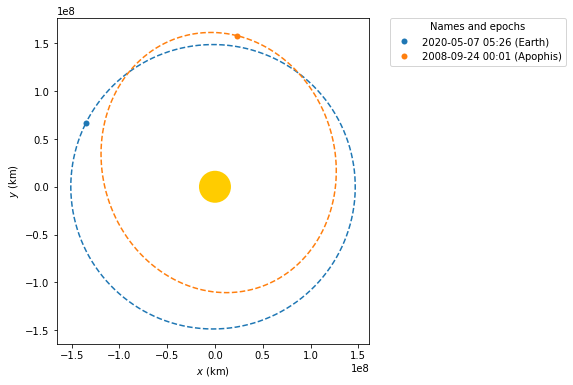

In [29]:
#Plotting the orbits
frame = StaticOrbitPlotter()

frame.plot(earth, label='Earth')
frame.plot(Apophis, label='Apophis')

#### Computing and plotting orbits manually 



In [10]:
#Required packages
import numpy as np
import matplotlib.pyplot as plt

#### Simulating the two-body dynamics with the Sun as central body

In [38]:
def twobody_dyn(X0, period):
    
    # X0: initial state [position, velocity]
    # period: Orbit period in days
    
    # Initial condition
    x, y, z, v_x, v_y, v_z = X0
    
    x_l = []
    y_l = []
    z_l = []
    
    # Time
    t = 0.0 # s
    dt = 0.01*24*60*60 # s

    # Sun gravitional constant
    G = 6.67408e-20 # km^3 kg^-1 s^-2
    # mass of the Sun
    m_S = 1.989e30 # kg 

    mu = G*m_S # km^3 s^-2

    while t < period*24*60*60:
        # Sun-Object distance
        r_S = np.sqrt((x)**2 + (y)**2 + (z)**2) # m

        # Euler numerical Method for solving ODE
        v_x += (-(mu*(x))/r_S**3)*dt
        v_y += (-(mu*(y))/r_S**3)*dt
        v_z += (-(mu*(z))/r_S**3)*dt

        x += v_x*dt
        y += v_y*dt
        z += v_z*dt
        
        t += dt

        x_l.append(x)
        y_l.append(y)
        z_l.append(z)
        
    return x_l, y_l, z_l

In [39]:
#### Earth ###
#Initial Position
x_0e, y_0e, z_0e = 1.5e8, 0, 0 #km

#Initial Velocity
vx_0e, vy_0e, vz_0e = 0, 30, 0 #km/s

#Initial state
X0e = [x_0e, y_0e, z_0e, vx_0e, vy_0e, vz_0e]

#Period
period_e = 375

xe, ye, ze = twobody_dyn(X0e, period_e)

In [40]:
#### Asteroid Apophis ###
#Initial Position
x_0a, y_0a, z_0a = -1.6e08, 1.7e07, -4.8e06 #km

#Initial Velocity
vx_0a, vy_0a, vz_0a = -0.4255, -26.104, 1.373 #km/s

#Initial state
X0a = [x_0a, y_0a, z_0a, vx_0a, vy_0a, vz_0a]

#Period
period_a = 320

xa, ya, za = twobody_dyn(X0a, period_a)

Text(0, 0.5, '$y (m)$')

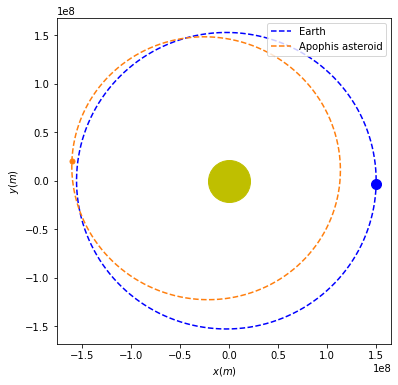

In [41]:
#PLotting the orbits
plt.figure(figsize=(6,6))

#Earth
plt.plot(xe, ye, '--b', label='Earth')
xef, yef = xe[len(xe)-1], ye[len(ye)-1]
plt.plot([xef], [yef], 'ob', markersize=10)

#Apophis
plt.plot(xa, ya, '--C1', label='Apophis asteroid')
xaf, yaf = xa[len(xa)-1], ya[len(ya)-1]
plt.plot([xaf], [yaf], 'oC1', markersize=5)

plt.plot([0], [0], 'oy', markersize=42)

plt.legend(loc='upper right',fontsize=10)
plt.xlabel("$x (m)$")
plt.ylabel("$y (m)$")

### Lagrange Points coordinates retrieval

The position vectors of the 5 lagrange points in the normalized barycentric rotating frame are

\begin{align}
r_{L_1} =& \begin{bmatrix}
1 - \mu - \left(\frac{\mu}{3}\right)^{1/3} & 0 & 0 
\end{bmatrix} \\[.3em]
r_{L_2} =& \begin{bmatrix}
1 - \mu + \left(\frac{\mu}{3}\right)^{1/3} & 0 & 0
\end{bmatrix} \\[.3em]
r_{L_3} =& \begin{bmatrix}
- \left(1 + \frac{5}{12}\mu\right) & 0 & 0 
\end{bmatrix} \\[.3em]
r_{L_4} =& \begin{bmatrix}
\frac{1}{2} - \mu & \frac{\sqrt{3}}{2} & 0  
\end{bmatrix} \\[.3em]
r_{L_5} =& \begin{bmatrix}
\frac{1}{2} - \mu & -\frac{\sqrt{3}}{2} & 0 
\end{bmatrix} 
\end{align}

For $L_1$ and $L_2$ the $x$ coordinates are approximations to the exact values

$\mu = \cfrac{m_2}{m_1+m_2}$ is the fundamental gravitational parameter 

For the sun earth system, we have $\mu = 3.04036\cdot 10^{-6} $

In [125]:
# Importing packages
import numpy as np

from astropy import units as u
from poliastro.threebody import restricted

#### Retrieving Lagrange points coordinates with Poliastro

In [126]:
r_SE = 1.5094e8 * u.km # Dstance between Sun and Earth (Astropy km unit)

m_S = 1.989e30 * u.kg # Mass of the Sun (Astropy kg unit)
m_E = 5.972e24 * u.kg # Mass of the Earth (Astropy kg unit)

# x coordinates of Lagrange points (relative to the sun) 
xL_poliastro = restricted.lagrange_points(r_SE, m_S, m_E)/r_SE

mu_SE = m_E/(m_E + m_S)

# Lagrange points coordinates 
Lagrange_points = {
'L1': [float(xL_poliastro[0]-mu), 0, 0],
'L2': [float(xL_poliastro[1]-mu), 0, 0],
'L3': [float(xL_poliastro[2]+mu), 0, 0],
'L4': [float(xL_poliastro[3]-mu), np.sqrt(3)/2, 0], 
'L5': [float(xL_poliastro[4]-mu), -np.sqrt(3)/2, 0],
}

# Display
Lagrange_points

{'L1': [0.9900276710713848, 0, 0],
 'L2': [1.0100330267223054, 0, 0],
 'L3': [-0.9999952460337078, 0, 0],
 'L4': [0.499996997495189, 0.8660254037844386, 0],
 'L5': [0.499996997495189, -0.8660254037844386, 0]}

#### Retrieving Lagrange points coordinates manually

In [30]:
def LagrangeP_manual(m1, m2):
    
    # Fundamental parameter
    mu = m2/(m1 + m2)
    
    # Calculate Lagrange points coordinates
    Lagrange = {
    'L1': [1 - mu - (mu/3)**(1/3), 0, 0], 
    'L2': [1 - mu + (mu/3)**(1/3), 0, 0],
    'L3': [-(1 + 5*mu/12), 0, 0],
    'L4': [0.5 - mu, np.sqrt(3)/2, 0], 
    'L5': [0.5 - mu, np.sqrt(3)/2, 0], 
    }
    return Lagrange

In [31]:
#mu = 3.040357143*10**-6
mS = 1.989e30 #Mass of the sun
mE = 5.972e24 # Mass of the earth

LP_manual = LagrangeP_manual(mS, mE)

# Display
LP_manual

{'L1': [0.9899942151460952, 0, 0],
 'L2': [1.0099997798442828, 0, 0],
 'L3': [-1.0000012510436713, 0, 0],
 'L4': [0.499996997495189, 0.8660254037844386, 0],
 'L5': [0.499996997495189, 0.8660254037844386, 0]}